In [136]:
## JPF HELPFUL WEBSITES:
    ## https://biokamikazi.wordpress.com/2016/07/05/machine-learning-with-knn-classifier/
    ## https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/
    ## https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
    ## http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html
    ## http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html

In [137]:
import numpy as np
import pandas as pd 
from pandas.io import sql
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

import psycopg2

%matplotlib inline

## Pre-Task: Describe the goals of your study

Based on the data provided of 891 passenger records, determine what factors (age, sex, class, etc.) may be influential in a model to determine passenger survival of the titanic disaster. 

## Part 1: Acquire the Data

### VARIABLE DESCRIPTIONS:
<pre>
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
</pre>

#### 1. Connect to the remote database

In [138]:
conn = psycopg2.connect(database='titanic', user='dsi_student', password='gastudents', \
                        host='dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com', port='5432', sslmode='require')

#### 2. Query the database and aggregate the data

In [139]:
df = sql.read_sql('select * from train', con=conn)

#### 5. What are the risks and assumptions of our data? 

We assume that the sample provided is a random representation of all the passengers and that the information is generally accurate. 

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [140]:
#SET ALL COLs to lowercase

col_list = [x.lower() for x in df.columns]
df.columns = col_list

In [141]:
print "AGE: ", df['age'].sort_values().unique()
print "SIBSP: ", df['sibsp'].unique()
print "PARCH: ", df['parch'].unique()
print "PCLASS: ", df['pclass'].unique()
print "SURVIVOR: ", df['survived'].unique()
print "SEX: ", df['sex'].unique()
print "FARE: ", df['fare'].sort_values().unique()
print "CABIN: ", df['cabin'].sort_values().unique()

AGE:  [  0.42   0.67   0.75   0.83   0.92   1.     2.     3.     4.     5.     6.
   7.     8.     9.    10.    11.    12.    13.    14.    14.5   15.    16.
  17.    18.    19.    20.    20.5   21.    22.    23.    23.5   24.    24.5
  25.    26.    27.    28.    28.5   29.    30.    30.5   31.    32.    32.5
  33.    34.    34.5   35.    36.    36.5   37.    38.    39.    40.    40.5
  41.    42.    43.    44.    45.    45.5   46.    47.    48.    49.    50.
  51.    52.    53.    54.    55.    55.5   56.    57.    58.    59.    60.
  61.    62.    63.    64.    65.    66.    70.    70.5   71.    74.    80.
    nan]
SIBSP:  [1 0 3 4 2 5 8]
PARCH:  [0 1 2 5 3 4 6]
PCLASS:  [3 1 2]
SURVIVOR:  [0 1]
SEX:  ['male' 'female']
FARE:  [   0.        4.0125    5.        6.2375    6.4375    6.45      6.4958
    6.75      6.8583    6.95      6.975     7.0458    7.05      7.0542
    7.125     7.1417    7.225     7.2292    7.25      7.3125    7.4958
    7.5208    7.55      7.6292    7.65      7.72

In [142]:
df.describe()

,index,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 2. Visualize the Data

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
passengerid    891 non-null int64
survived       891 non-null int64
pclass         891 non-null int64
name           891 non-null object
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
ticket         891 non-null object
fare           891 non-null float64
cabin          204 non-null object
embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [144]:
#FILL 2 missing EMBARKED with mode of EMBARKED

mode_embarked = df['embarked'].mode()
nan_embark_list = []

for i in range(0,df['embarked'].isnull().sum()):
    nan_embark_list.append(mode_embarked)
    i += 1
try:     
    df['embarked'][df['embarked'].isnull()] = nan_embark_list
except: pass


/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [145]:
#FILL ages with random known age. 
age_list = df[df['age'].notnull()]['age'].tolist()
nan_age_len = df['age'].isnull().sum()
nan_age_list = []
for i in range(0,df['age'].isnull().sum()):
    nan_age_list.append(age_list[np.random.randint(min(age_list),max(age_list),1)])
    i += 1
try:     
    df["age"][df['age'].isnull()] = nan_age_list
except: pass

/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
#ASSIGN child if age < 13 else ADULT
df['age_group'] = df['age'].apply(lambda x: 'Child' if x < 13 else 'Adult')
df['age_group'].unique()

array(['Adult', 'Child'], dtype=object)

In [147]:
#CREATE party_size from parch and sibsp
df['party_num'] = df['parch'] + df['sibsp'] + 1

#BIN PARTY_SIZE Small, Medium, Large
df['party_size'] = 'M'
df.loc[df['party_num'] < 2, 'party_size'] = 'S' 
df.loc[df['party_num'] > 4, 'party_size'] = 'L' 

In [148]:
df.isnull().sum()

index            0
passengerid      0
survived         0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         0
age_group        0
party_num        0
party_size       0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132f07a50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ff81ad0>]], dtype=object)

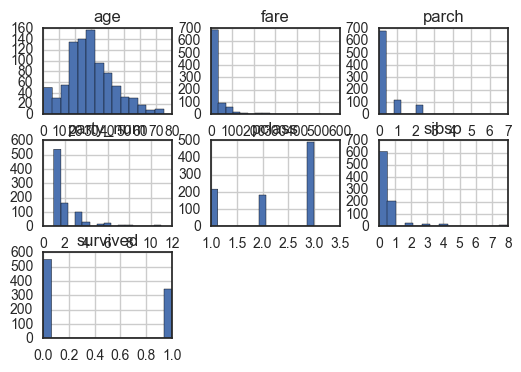

In [149]:
df.hist(column=['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'party_num'], bins=15)

In [150]:
pd.crosstab(df.sex, df.survived, margins=True)

survived,0,1,All
sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


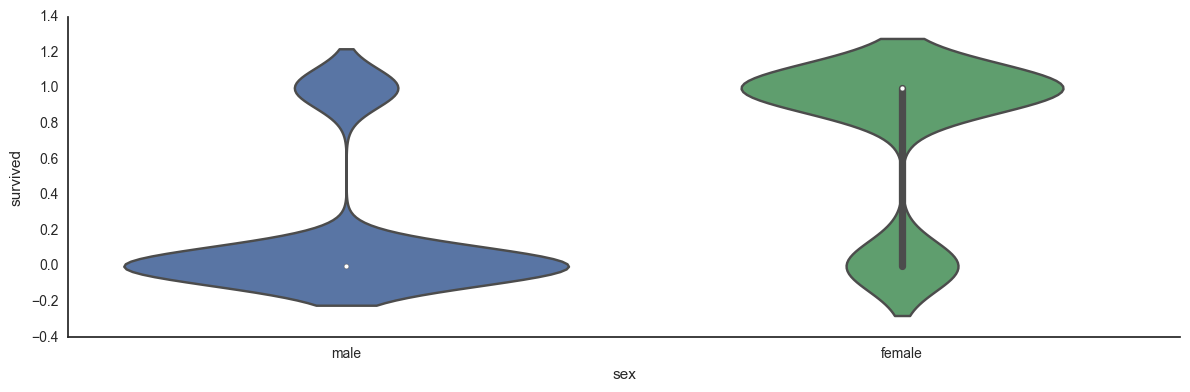

In [151]:
sns.factorplot('sex','survived', data=df,size=4,aspect=3, kind='violin')
#FEMALES SURVIVE MALES DO NOT

In [152]:
pd.crosstab(df.age_group, df.survived, margins=True)

survived,0,1,All
age_group,,,
Adult,510,300,810
Child,39,42,81
All,549,342,891


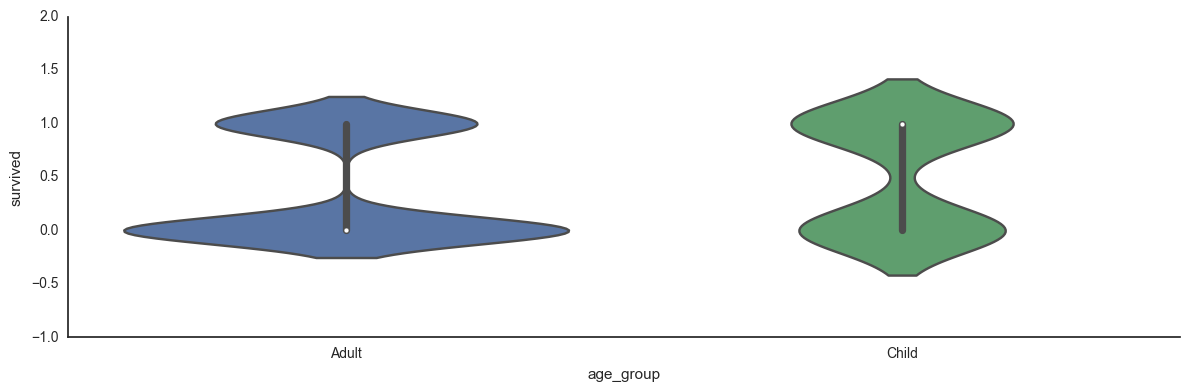

In [153]:
    sns.factorplot('age_group','survived', data=df,size=4,aspect=3, kind='violin')
    #CHILDREN 50/50 SURVIVAL 
    #ADULTS LESS LIKELY 

In [154]:
pd.crosstab(df.party_size, df.survived, margins=True)

survived,0,1,All
party_size,,,
L,52,10,62
M,123,169,292
S,374,163,537
All,549,342,891


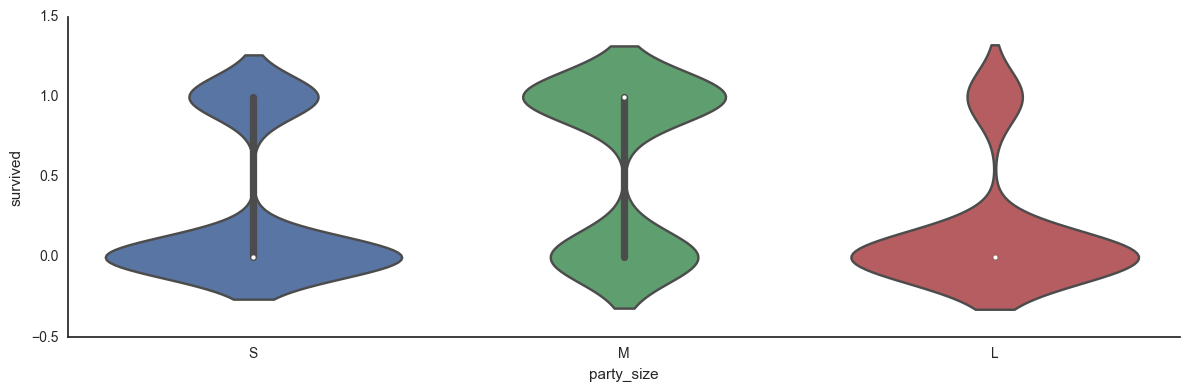

In [155]:
sns.factorplot('party_size','survived', data=df,size=4,aspect=3, kind='violin', order=['S', 'M', 'L'])
#SMALL and LARGE PARTIES LESS SURVIVAL
#MEDIUM SIZED 50/50 SURVIVAL

In [156]:
pd.crosstab(df.embarked, df.survived, margins=True)

survived,0,1,All
embarked,,,
C,75,93,168
Q,47,30,77
S,427,219,646
All,549,342,891


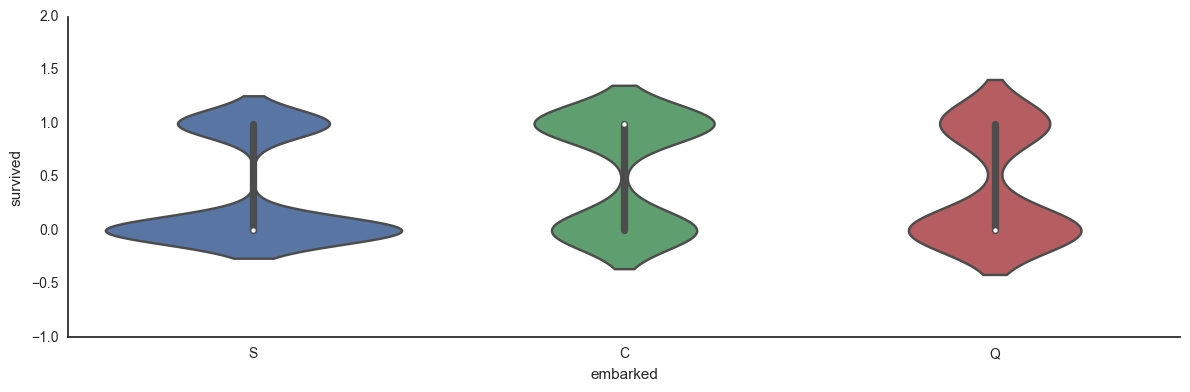

In [157]:
sns.factorplot('embarked','survived', data=df,size=4,aspect=3, kind='violin')
#SOUTHAMPTON LESS SUVIVAL
#OTHERS 50/50

In [158]:
pd.crosstab(df.pclass, df.survived, margins=True)

survived,0,1,All
pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


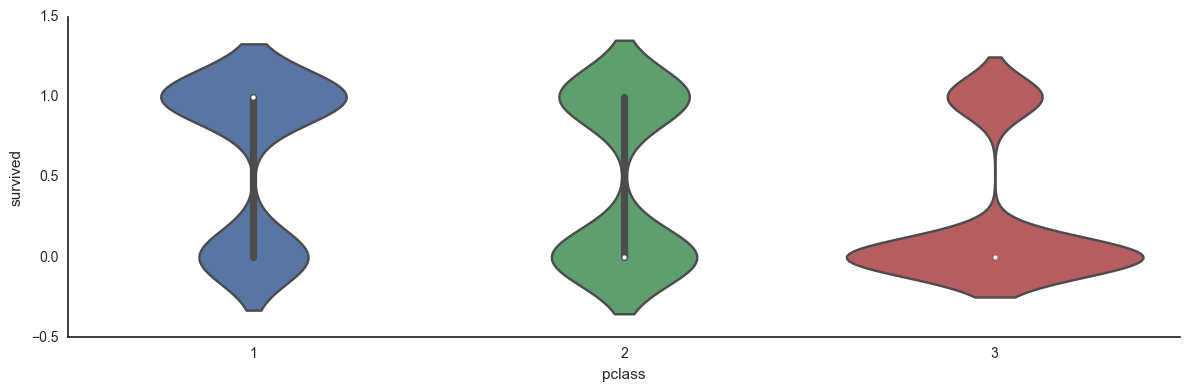

In [159]:
sns.factorplot('pclass','survived', data=df,size=4,aspect=3, kind='violin')
#1st CLASS BETTER SURVIVAL THAN 2nd
#3rd LEAST SURVIVAL

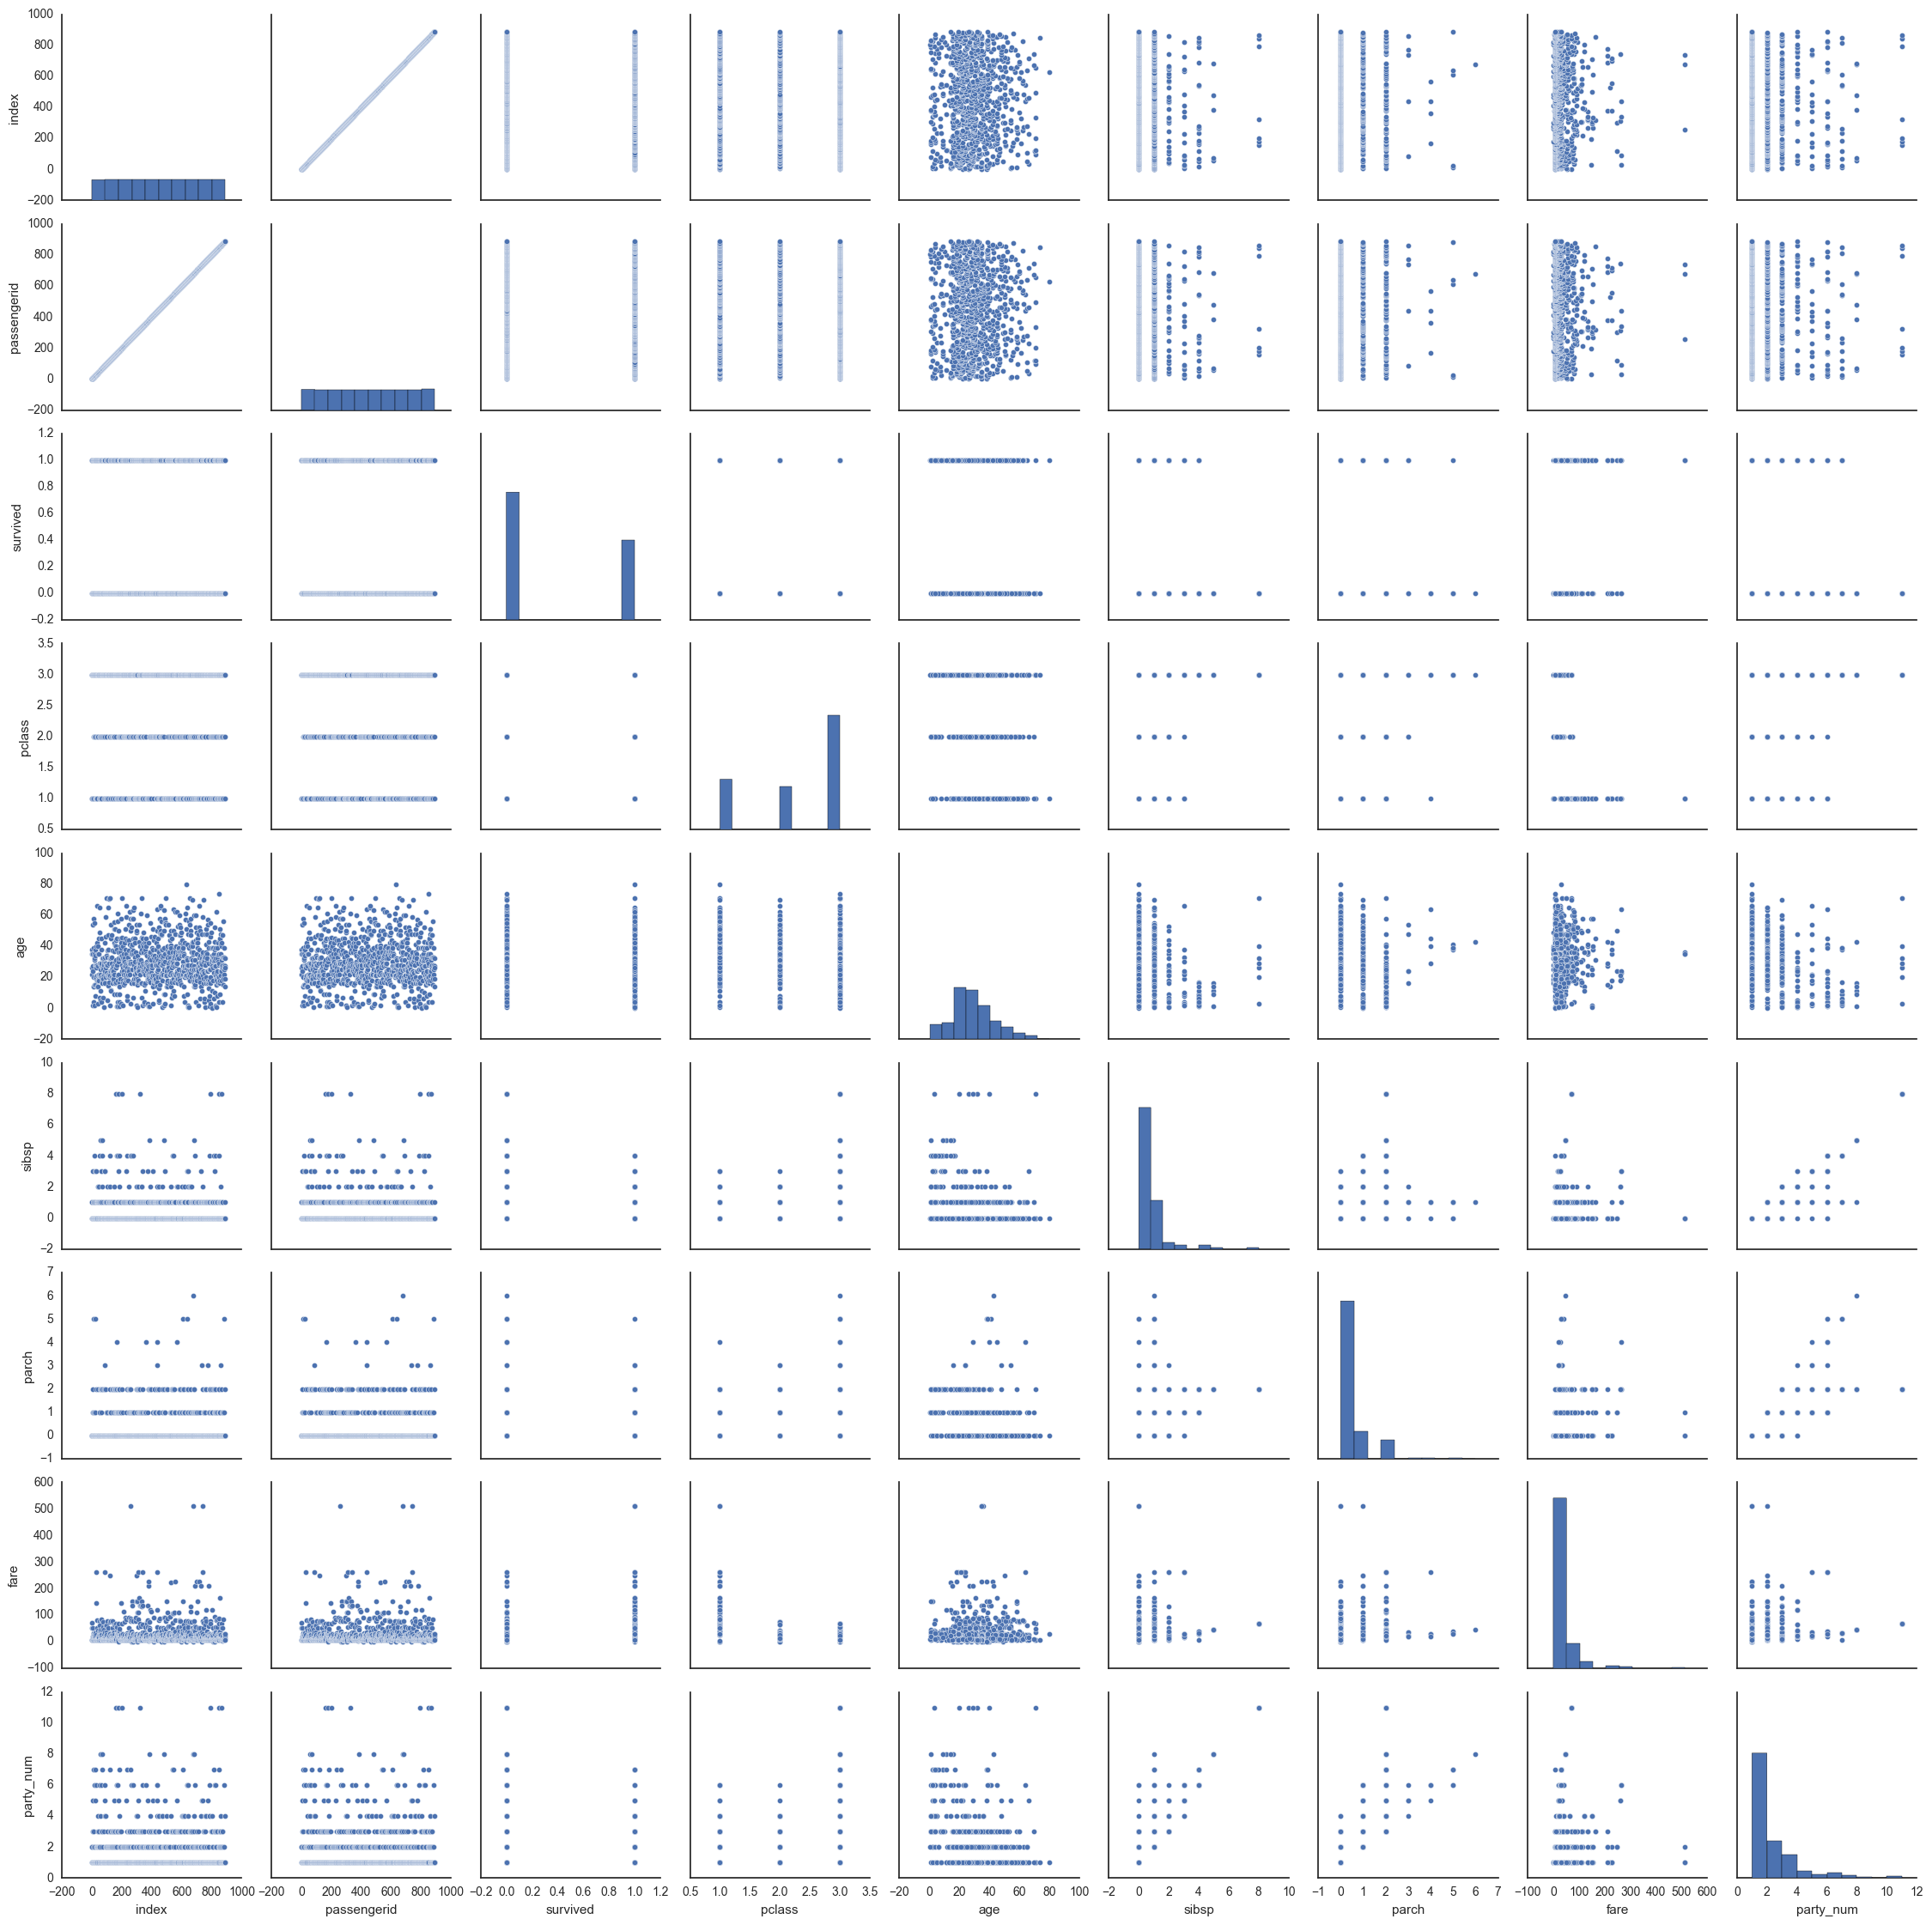

In [160]:
sns.pairplot(df)

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [161]:
train = df.copy()

In [162]:
train.columns.tolist

train.drop([u'index', u'passengerid', u'name', u'sibsp', u'parch', u'ticket', u'cabin'], axis=1, inplace=True)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [163]:


features = patsy.dmatrix('~C(pclass)+C(sex)+age+fare+C(embarked)+C(age_group)+C(party_size)+C(party_num)',\
                  train)
cols = features.design_info.column_names

X = pd.DataFrame(features, columns=cols)
y = train['survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

# make df of just age and fare 
from sklearn.preprocessing import StandardScaler
##X =  StandardScaler().fit_transform(X)
scaler = StandardScaler().fit(X_train[['age', 'fare']])
X_train_norm = scaler.transform(X_train[['age', 'fare']])
X_test_norm = scaler.transform(X_test[['age', 'fare']])

X_train['age'] = X_train_norm[:,0]
X_train['fare'] = X_train_norm[:,1]
X_test['age'] = X_test_norm[:,0]
X_test['fare'] = X_test_norm[:,1]


/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

#### 3. Conduct the logistic regression

In [164]:
lr = LogisticRegression(solver='liblinear')
lr_model = lr.fit(X_train, y_train)

#### 4. Examine the coefficients to see our correlations

In [206]:
log_coef = pd.DataFrame([X_train.columns, lr_model.coef_[0]], index=['features', 'coef']).T
log_coef['abs_coef'] = abs(log_coef['coef'])
log_coef.sort_values(by='abs_coef', ascending=False).head(10)


,features,coef,abs_coef
3,C(sex)[T.male],-2.37984,2.37984
2,C(pclass)[T.3],-1.51543,1.51543
8,C(party_size)[T.S],1.34893,1.34893
7,C(party_size)[T.M],1.13712,1.13712
6,C(age_group)[T.Child],0.897915,0.897915
10,C(party_num)[T.3],0.752987,0.752987
16,C(party_num)[T.11],-0.710913,0.710913
13,C(party_num)[T.6],-0.650049,0.650049
12,C(party_num)[T.5],-0.645942,0.645942
1,C(pclass)[T.2],-0.544018,0.544018


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [166]:
lr_tts = LogisticRegression(solver='liblinear')
lr_tts.fit(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [167]:
lr_ypred = lr_tts.predict(X_test)
lr_ypred.shape

(295,)

#### 8. Predict the class probabilities for the *Test* set

In [168]:
proba = lr_tts.predict_proba(X_test)
proba

array([[ 0.41387436,  0.58612564],
       [ 0.18888941,  0.81111059],
       [ 0.89283512,  0.10716488],
       [ 0.72965472,  0.27034528],
       [ 0.92194991,  0.07805009],
       [ 0.90502467,  0.09497533],
       [ 0.27299568,  0.72700432],
       [ 0.78896287,  0.21103713],
       [ 0.89623706,  0.10376294],
       [ 0.72583407,  0.27416593],
       [ 0.95463247,  0.04536753],
       [ 0.9070136 ,  0.0929864 ],
       [ 0.90105166,  0.09894834],
       [ 0.91157609,  0.08842391],
       [ 0.81310985,  0.18689015],
       [ 0.51993749,  0.48006251],
       [ 0.86516989,  0.13483011],
       [ 0.74378111,  0.25621889],
       [ 0.75085757,  0.24914243],
       [ 0.65463404,  0.34536596],
       [ 0.90849594,  0.09150406],
       [ 0.14496688,  0.85503312],
       [ 0.89260228,  0.10739772],
       [ 0.81842336,  0.18157664],
       [ 0.10941013,  0.89058987],
       [ 0.89492256,  0.10507744],
       [ 0.35259427,  0.64740573],
       [ 0.73058628,  0.26941372],
       [ 0.50527575,

#### 9. Evaluate the *Test* set

In [169]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, lr_ypred)
print(acc)

0.833898305085


#### 10. Cross validate the test set

In [170]:
cvls = cross_val_score(lr_tts, X_test, y_test, n_jobs=1, cv=10)
cvls.mean()

0.81425287356321829

#### 11. Check the Classification Report

In [171]:
from sklearn.metrics import classification_report

# Example printout:
print(classification_report(y_test, lr_ypred))

             precision    recall  f1-score   support

          0       0.84      0.91      0.87       185
          1       0.82      0.71      0.76       110

avg / total       0.83      0.83      0.83       295



#### 12. What do the classification metrics tell us?

##FROM SKLEARN DOCS
A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

##FROM http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
Precision can be thought of as a measure of a classifiers exactness. A low precision can also indicate a large number of False Positives.
Recall can be thought of as a measure of a classifiers completeness. A low recall indicates many False Negatives.


#### 13. Check the Confusion Matrix

In [172]:
from sklearn.metrics import confusion_matrix

conmat = np.array(confusion_matrix(y_test, lr_ypred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['survived', 'died'],
                         columns=['predicted_survived','predicted_died'])

print(confusion)


          predicted_survived  predicted_died
survived                  78              32
died                      17             168


#### 14. What does the Confusion Matrix tell us? 

We are pretty good at predicting death. 

#### 15. Plot the ROC curve

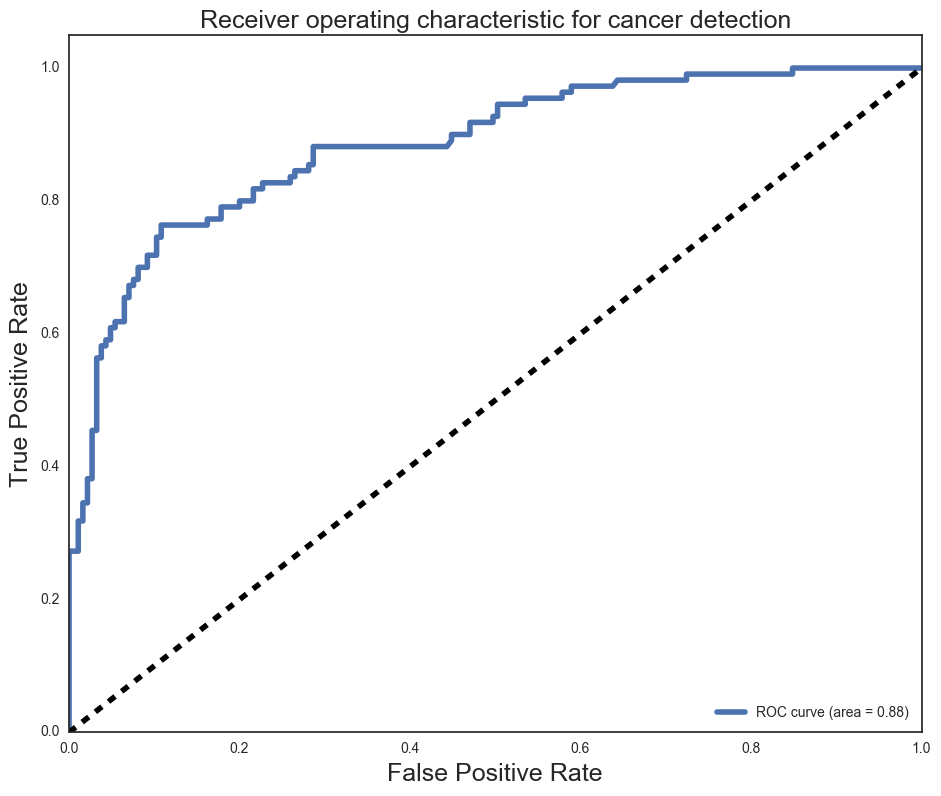

In [173]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = lr_tts.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [174]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [175]:
gs = GridSearchCV(lr_tts, logreg_parameters,\
                  verbose=False, cv=15)
gs.fit(X_train, y_train)
y_scores_gs_lr = gs.decision_function(X_test)

In [176]:
print "params: ",gs.best_params_
print "score: ",gs.best_score_

params:  {'penalty': 'l1', 'C': 0.33932217718953295, 'solver': 'liblinear'}
score:  0.807046979866


#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

Both lasso and ridge impose a penalty for the predictions, Lasso, because of its diamond shape tends to eliminate features. Ridge tends to reduce feature importance, but not necessarily eliminate. 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

when the desire to reduce model complexity and/or interpretability is helpful

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

the penalty, C, is an inverse of the lambda. A large C imposes a stronger pull on the optimal point for a set a features. 

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [177]:
########     w4d2-evaluating-model-fit-AUC-ROC-codealong  #############

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [178]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_dict = dict(n_neighbors=range(1, 31),\
                  weights=['uniform', 'distance'])
gsknncv = GridSearchCV(knn, param_dict, scoring='accuracy')
gscv_model = gsknncv.fit(X_train, y_train)




#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [179]:
print "params: ",gscv_model.best_params_
best_param_dict = gscv_model.best_params_
print "score: ",gscv_model.best_score_
gscv_best = gscv_model.best_estimator_


params:  {'n_neighbors': 8, 'weights': 'uniform'}
score:  0.796979865772


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

The larger the number of neighbors, the less variance and more bias. 
As k increaes to size of dataset, you approach the mean. 

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [180]:
y_best_pred = gscv_best.predict(X_test)

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [181]:
conmat = np.array(confusion_matrix(y_test, y_best_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['survived', 'died'],
                         columns=['predicted_survived','predicted_died'])

print(confusion)

          predicted_survived  predicted_died
survived                  68              42
died                      22             163



#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

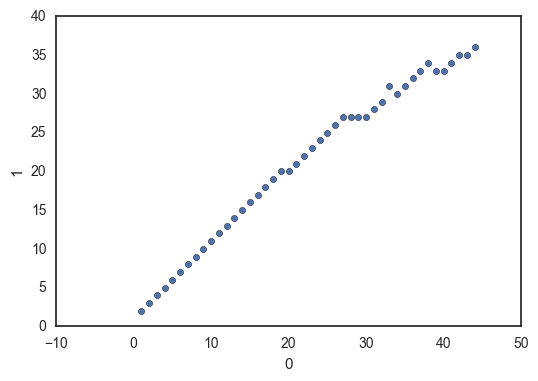

In [182]:
unique_vals = []
for i in range(1,45):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    clf.fit(X_train, y_train)
    knn_y_scores = clf.predict_proba(X_test)[:,1]
    unique_vals.append([i, pd.DataFrame(knn_y_scores)[0].nunique()])
pd.DataFrame(unique_vals).plot(x=0, y=1, kind='scatter')

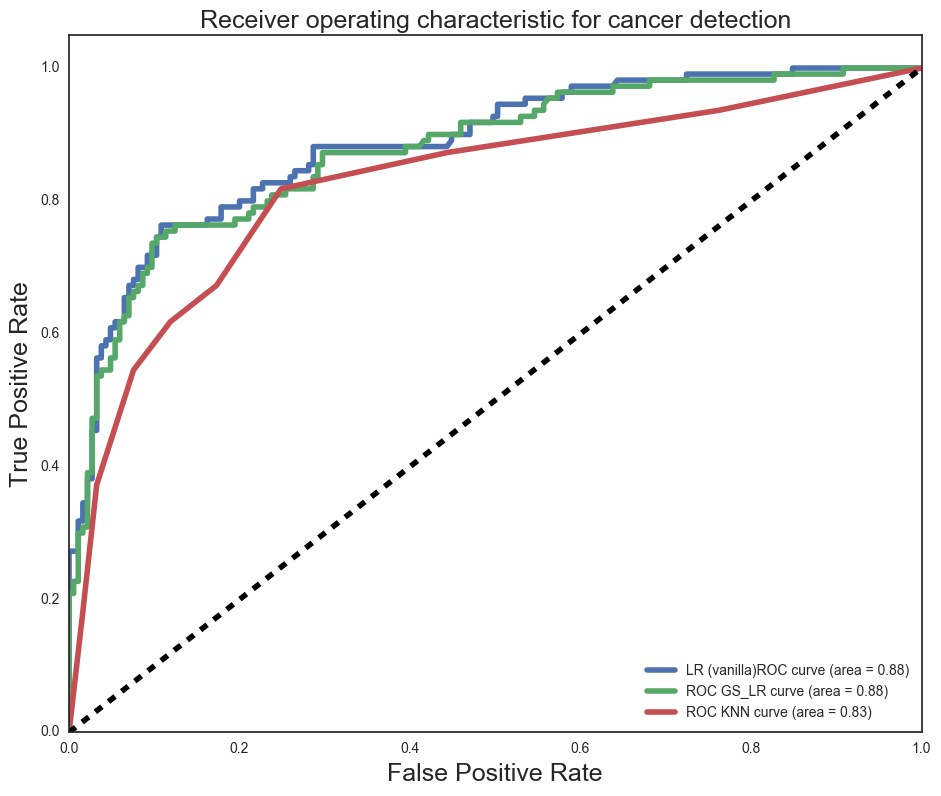

In [183]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = lr_tts.decision_function(X_test)
knn_y_scores = gscv_best.predict_proba(X_test)[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
FPR[2], TPR[2], _ = roc_curve(y_test, y_scores_gs_lr)
ROC_AUC[2] = auc(FPR[2], TPR[2])
FPR[3], TPR[3], _ = roc_curve(y_test, knn_y_scores)
ROC_AUC[3] = auc(FPR[3], TPR[3])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='LR (vanilla)ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR[2], TPR[2], label='ROC GS_LR curve (area = %0.2f)' % ROC_AUC[2], linewidth=4)
plt.plot(FPR[3], TPR[3], label='ROC KNN curve (area = %0.2f)' % ROC_AUC[3], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [184]:
gsap = GridSearchCV(lr_tts, logreg_parameters,\
                  verbose=False, cv=15, scoring='average_precision')
gsap.fit(X_train, y_train)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=False)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [185]:
print "Params: ", gsap.best_params_
print "Score: ", gsap.best_score_
gsap_pred = gsap.predict(X_test)
y_score = gsap.decision_function(X_test)

Params:  {'penalty': 'l2', 'C': 1.0481131341546852, 'solver': 'liblinear'}
Score:  0.820603349239


#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [186]:
conmat = np.array(confusion_matrix(y_test, gsap_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['survived', 'died'],
                         columns=['predicted_survived','predicted_died'])

print(confusion)

          predicted_survived  predicted_died
survived                  82              28
died                      22             163


#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

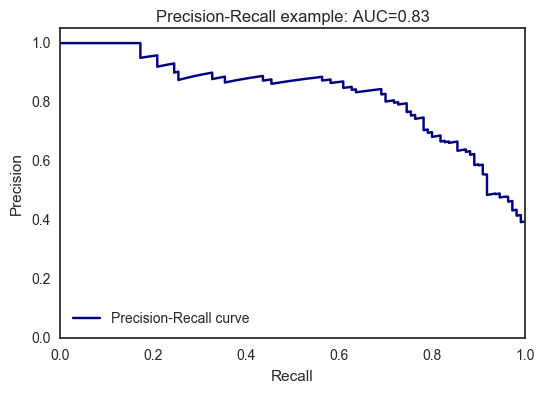

In [187]:

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
# n_classes = 1
# for i in range(n_classes):
precision[0], recall[0], _ = precision_recall_curve(y_test,
                                                    y_score)
average_precision[0] = average_precision_score(y_test, y_score)

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()


## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

In [213]:
## http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
## http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html

from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [214]:
from time import time
from operator import itemgetter

def report(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 3)
    return  top_params
###
###
###
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt = DecisionTreeClassifier()
ts_gs = run_gridsearch(X_test, y_test, dt, param_grid, cv=10)


GridSearchCV took 17.98 seconds for 288 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.841 (std: 0.073)
Parameters: {'min_samples_split': 2, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}

Model with rank: 2
Mean validation score: 0.841 (std: 0.073)
Parameters: {'min_samples_split': 10, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}

Model with rank: 3
Mean validation score: 0.837 (std: 0.059)
Parameters: {'min_samples_split': 10, 'max_leaf_nodes': 20, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}



#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

In [215]:
print "------ 10-fold Logistic Regression GridSearch"
param_grid = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

dt = LogisticRegression()
lr_ts_gs = run_gridsearch(X_test, y_test, dt, param_grid, cv=10)


print "------ 10-fold KNN GridSearch"
param_grid = dict(n_neighbors=range(1, 31),\
                  weights=['uniform', 'distance'])

dt = KNeighborsClassifier()
knn_ts_gs = run_gridsearch(X_test, y_test, dt, param_grid, cv=10)

print "------ 10-fold DecisionTree GridSearch"
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

dt = DecisionTreeClassifier()
dt_ts_gs = run_gridsearch(X_test, y_test, dt, param_grid, cv=10)

------ 10-fold Logistic Regression GridSearch

GridSearchCV took 10.53 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.081)
Parameters: {'penalty': 'l1', 'C': 0.79060432109077017, 'solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.827 (std: 0.074)
Parameters: {'penalty': 'l1', 'C': 1.3894954943731359, 'solver': 'liblinear'}

Model with rank: 3
Mean validation score: 0.827 (std: 0.074)
Parameters: {'penalty': 'l1', 'C': 1.8420699693267164, 'solver': 'liblinear'}

------ 10-fold KNN GridSearch

GridSearchCV took 6.34 seconds for 60 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.790 (std: 0.079)
Parameters: {'n_neighbors': 12, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.790 (std: 0.069)
Parameters: {'n_neighbors': 15, 'weights': 'uniform'}

Model with rank: 3
Mean validation score: 0.786 (std: 0.087)
Parameters: {'n_neighbors': 9, 'weights': 'uniform'}

------ 10-fold D

#### 3. Plot all three optimized models' ROC curves on the same plot. 

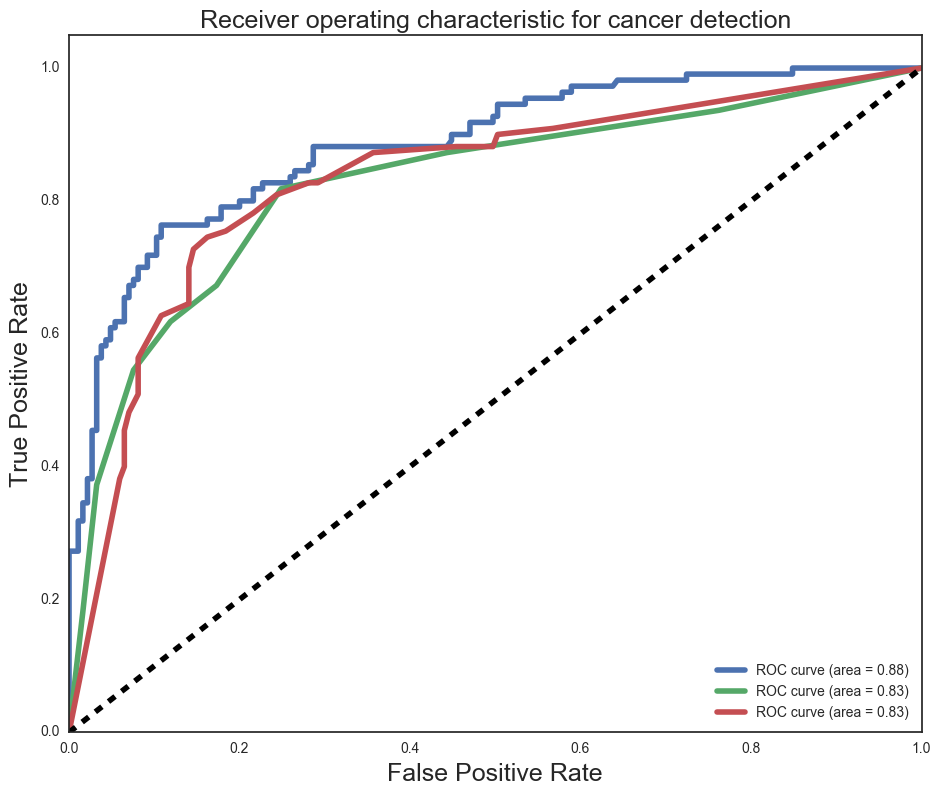

In [226]:
dt = DecisionTreeClassifier(**dt_ts_gs)
dt.fit(X_train, y_train)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = lr_tts.decision_function(X_test)
knn_y_scores = gscv_best.predict_proba(X_test)[:,1]
dt_y_scores = dt.predict_proba(X_test)[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
FPR[2], TPR[2], _ = roc_curve(y_test, knn_y_scores)
ROC_AUC[2] = auc(FPR[2], TPR[2])
FPR[3], TPR[3], _ = roc_curve(y_test, dt_y_scores)
ROC_AUC[3] = auc(FPR[3], TPR[3])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR[2], TPR[2], label='ROC curve (area = %0.2f)' % ROC_AUC[2], linewidth=4)
plt.plot(FPR[3], TPR[3], label='ROC curve (area = %0.2f)' % ROC_AUC[3], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

In [218]:
### https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(dt)
bag_clf.fit(X_train, y_train)
bag_y_scores = bag_clf.predict_proba(X_test)[:,1]
bag_pred = bag_clf.predict(X_test)

In [219]:
acc = accuracy_score(y_test, bag_pred)
print "Accuracy", acc
bag_cvls = cross_val_score(bag_clf, X_test, y_test, n_jobs=1, cv=10)
print "Mean CV Score (10-fold): ", bag_cvls.mean()

Accuracy 0.840677966102
Mean CV Score (10-fold):  0.790229885057


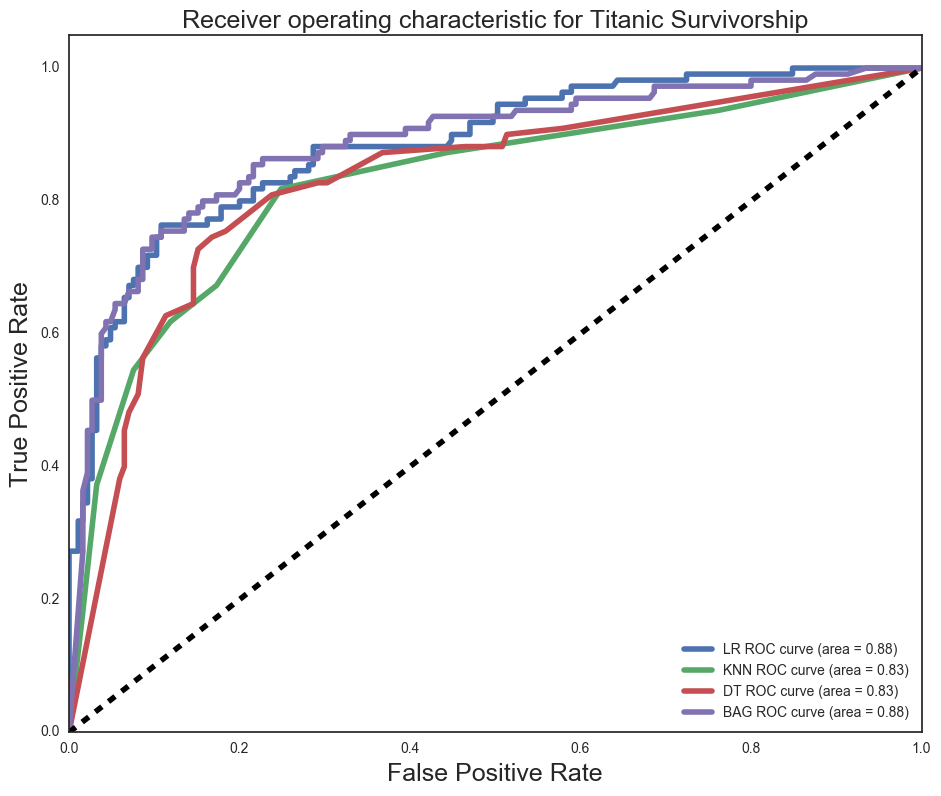

In [221]:
dt = DecisionTreeClassifier(**dt_ts_gs)
dt.fit(X_train, y_train)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = lr_tts.decision_function(X_test)
knn_y_scores = gscv_best.predict_proba(X_test)[:,1]
dt_y_scores = dt.predict_proba(X_test)[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
FPR[2], TPR[2], _ = roc_curve(y_test, knn_y_scores)
ROC_AUC[2] = auc(FPR[2], TPR[2])
FPR[3], TPR[3], _ = roc_curve(y_test, dt_y_scores)
ROC_AUC[3] = auc(FPR[3], TPR[3])
FPR[4], TPR[4], _ = roc_curve(y_test, bag_y_scores)
ROC_AUC[4] = auc(FPR[4], TPR[4])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='LR ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR[2], TPR[2], label='KNN ROC curve (area = %0.2f)' % ROC_AUC[2], linewidth=4)
plt.plot(FPR[3], TPR[3], label='DT ROC curve (area = %0.2f)' % ROC_AUC[3], linewidth=4)
plt.plot(FPR[4], TPR[4], label='BAG ROC curve (area = %0.2f)' % ROC_AUC[4], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Titanic Survivorship', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

In [222]:
from sklearn.ensemble import BaggingClassifier
print "------ 10-fold Bagging Classifier GridSearch"
# param_grid = {"n_estimators": [10,100,500,1000],
#               "max_samples": [0.1, 0.5, 0.75, 1.0],
#               "max_features": [0.1, 0.5, 0.75, 1.0],
#               }

# dt_bc = BaggingClassifier()
# dt_bc_gs = run_gridsearch(X_test, y_test, dt_bc, param_grid, cv=10)

##RUNNING WITH THE BEST PARAMS FROM LENGTHY EXECUTION ABOVE
param_grid = {"n_estimators": [500],
               "max_samples": [0.5],
               "max_features": [0.75],
               }

dt_bc = BaggingClassifier()
dt_bc_gs = run_gridsearch(X_test, y_test, dt_bc, param_grid, cv=10)

------ 10-fold Bagging Classifier GridSearch

GridSearchCV took 25.14 seconds for 1 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.824 (std: 0.065)
Parameters: {'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 500}



RESULTS .. 22min to run previous cell....

------ 10-fold Bagging Classifier GridSearch

GridSearchCV took 1339.51 seconds for 64 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.834 (std: 0.059)
Parameters: {'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.831 (std: 0.066)
Parameters: {'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.831 (std: 0.066)
Parameters: {'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 1000}

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.

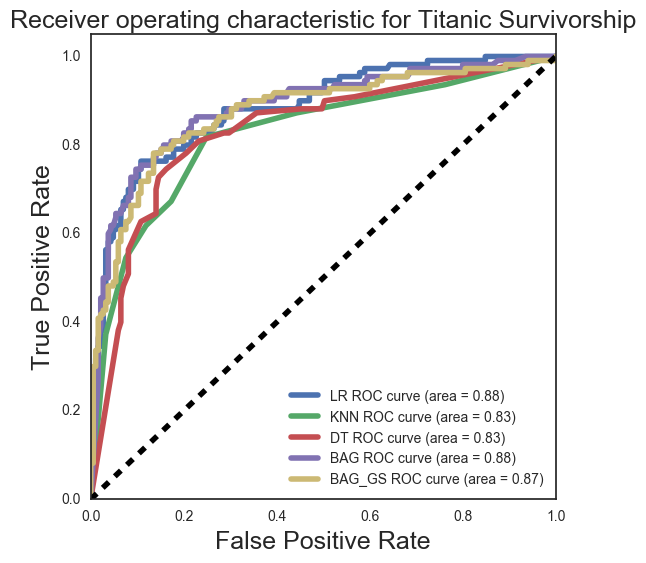

In [229]:
dt_best = BaggingClassifier(**dt_bc_gs)
dt_best.fit(X_train, y_train)
dt = DecisionTreeClassifier(**dt_ts_gs)
dt.fit(X_train, y_train)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = lr_tts.decision_function(X_test)
knn_y_scores = gscv_best.predict_proba(X_test)[:,1]
dt_y_scores = dt.predict_proba(X_test)[:,1]
dt_best_scores = dt_best.predict_proba(X_test)[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])
FPR[2], TPR[2], _ = roc_curve(y_test, knn_y_scores)
ROC_AUC[2] = auc(FPR[2], TPR[2])
FPR[3], TPR[3], _ = roc_curve(y_test, dt_y_scores)
ROC_AUC[3] = auc(FPR[3], TPR[3])
FPR[4], TPR[4], _ = roc_curve(y_test, bag_y_scores)
ROC_AUC[4] = auc(FPR[4], TPR[4])
FPR[5], TPR[5], _ = roc_curve(y_test, dt_best_scores)
ROC_AUC[5] = auc(FPR[5], TPR[5])


# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[6,6])
plt.plot(FPR[1], TPR[1], label='LR ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR[2], TPR[2], label='KNN ROC curve (area = %0.2f)' % ROC_AUC[2], linewidth=4)
plt.plot(FPR[3], TPR[3], label='DT ROC curve (area = %0.2f)' % ROC_AUC[3], linewidth=4)
plt.plot(FPR[4], TPR[4], label='BAG ROC curve (area = %0.2f)' % ROC_AUC[4], linewidth=4)
plt.plot(FPR[5], TPR[5], label='BAG_GS ROC curve (area = %0.2f)' % ROC_AUC[5], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Titanic Survivorship', fontsize=18)
plt.legend(loc="lower right")
plt.show()